# Lib loading


In [38]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

In [39]:
def normalize(dataset):
  zero_x, zero_y, zero_z = dataset.accel_x[0], dataset.accel_y[0], dataset.accel_z[0]
  dataset.accel_x -= zero_x
  dataset.accel_y -= zero_y
  dataset.accel_z -= zero_z

  zero_x, zero_y, zero_z = dataset.gyro_x[0], dataset.gyro_y[0], dataset.gyro_z[0]
  dataset.gyro_x -= zero_x
  dataset.gyro_y -= zero_y
  dataset.gyro_z -= zero_z

  return dataset

In [40]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Anna_flat_1/SM2_B1A104.csv"
dataset = pd.read_csv(url)
dataset = normalize(dataset)

In [41]:
dataset.head()

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000122,0.000000,-0.000977,-0.015259,-0.030518,-0.015259
2,0.000122,0.000122,-0.000977,-0.015259,-0.045776,0.000000
3,-0.000244,0.000122,-0.001343,-0.030518,0.000000,0.000000
4,-0.000244,0.000244,-0.001343,-0.030518,0.015259,0.000000


# Integration function


Here I'm going to approximate an integral by rectangles beneath the curve


In [42]:
def integrate(data, times):
    accumulated_speed = 0.0

    last_time = times[0]
    speeds = []

    for i in range(1, len(times)):
        time = times[i]

        delta_t = time - last_time
        delta_v = data[i] * delta_t

        accumulated_speed += delta_v

        speeds.append(accumulated_speed)
        last_time = time
    return speeds

# Gyro data explored

In [43]:
YAW_RATES = [dataset.gyro_x, dataset.gyro_y, dataset.gyro_z]
TIMESTAMPS    = np.arange(0, dataset.accel_z.size, 1)

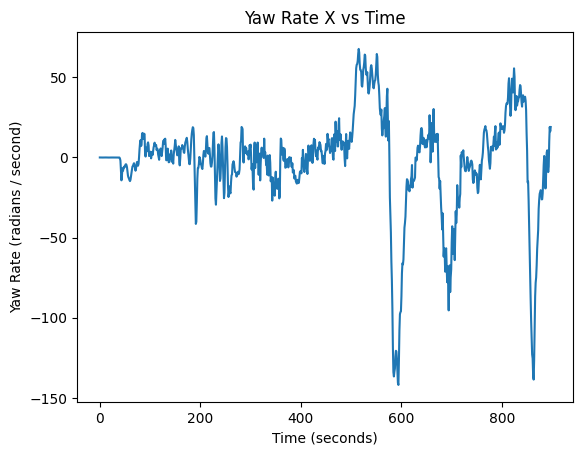

In [44]:
plt.title("Yaw Rate X vs Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Yaw Rate (radians / second)")
plt.plot(TIMESTAMPS, YAW_RATES[0])
plt.show()

In [45]:
def get_angle(YAW_RATES, TIMESTAMPS):
  thetas_x = integrate(YAW_RATES[0], TIMESTAMPS)
  thetas_y = integrate(YAW_RATES[1], TIMESTAMPS)
  thetas_z = integrate(YAW_RATES[2], TIMESTAMPS)

  ANGLES = [thetas_x, thetas_y, thetas_z]
  return ANGLES

In [46]:
ANGLES = get_angle(YAW_RATES, TIMESTAMPS)

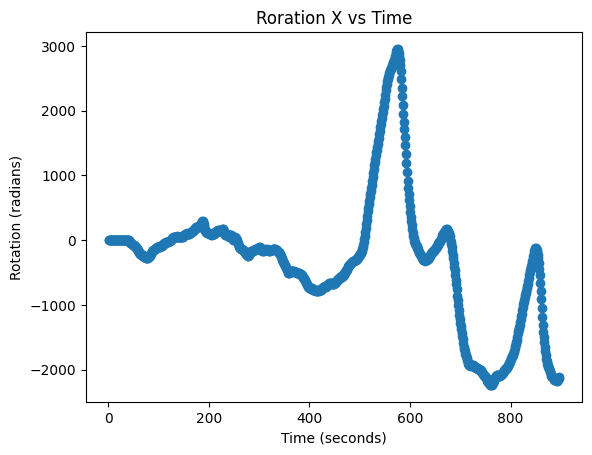

In [47]:
plt.title("Roration X vs Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Rotation (radians)")
plt.scatter(TIMESTAMPS[1:], ANGLES[0])
plt.show()

In [48]:
def get_rotation_matr(ANGLES):
  MATRICES = []

  for i in range(len(ANGLES[0])):
    alpha = (ANGLES[0][i]) #x
    beta = (ANGLES[1][i]) #y
    gamma = (ANGLES[2][i]) #z

    c_a, s_a = np.cos(alpha), np.sin(alpha)
    # R_x = np.array([[1, 0, 0], [0, c_a, -s_a], [0, s_a, c_a]])

    c_b, s_b = np.cos(beta), np.sin(beta)
    # R_y = np.array([[c_b, 0, s_b], [0, 1, 0], [-s_b, 0, c_b]])

    c_g, s_g = np.cos(gamma), np.sin(gamma)
    # R_z = np.array([[c_g, -s_g, 0], [s_g, c_g, 0], [0, 0, 1]])

    R = [[c_b*c_g, s_a*s_b*c_g - c_a*s_g, c_a*s_b*c_g + s_a*s_g],
         [c_b*s_g, s_a*s_b*s_g + c_a*c_g, c_a*s_b*s_g - s_a*c_g],
         [-s_b, s_a*c_b, c_a*c_b]]

    #MATRICES.append((R_z.dot(R_y)).dot(R_x))
    MATRICES.append(R)

  return MATRICES

# Gyro and Accelerometer data combined

In [49]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Anna_flat_1/SM2_B1A104.csv"
dataset = pd.read_csv(url)
dataset = normalize(dataset)

TIMESTAMPS    = np.arange(0, dataset.accel_z.size, 1)
YAW_RATES = [dataset.gyro_x, dataset.gyro_y, dataset.gyro_z]
ACCELERATIONS = [dataset.accel_x, dataset.accel_y, dataset.accel_z]

In [50]:
def callibrate(ACCELERATIONS, YAW_RATES, TIMESTAMPS):
  ANGLES = get_angle(YAW_RATES, TIMESTAMPS)
  MATRICES = get_rotation_matr(ANGLES)
  # print(len(MATRICES[0][0]))

  new_acc = [[], [], []]

  for i in range(len(MATRICES)):
    matrix = np.array(MATRICES[i])
    vector = np.array([ACCELERATIONS[0][i], ACCELERATIONS[1][i], ACCELERATIONS[2][i]])
    res = (matrix.dot(vector)).tolist()
    new_acc[0].append(res[0])
    new_acc[1].append(res[1])
    new_acc[2].append(res[2])

  return new_acc

In [51]:
def get_position(ACCELERATIONS, TIMESTAMPS):
  # Now we use the function we just defined
  integrated_speeds_x = integrate(ACCELERATIONS[0], TIMESTAMPS)
  integrated_displ_x = integrate(integrated_speeds_x,
                                                  TIMESTAMPS[1:])

  integrated_speeds_y = integrate(ACCELERATIONS[1], TIMESTAMPS)
  integrated_displ_y = integrate(integrated_speeds_y,
                                                  TIMESTAMPS[1:])

  integrated_speeds_z = integrate(ACCELERATIONS[2], TIMESTAMPS)
  integrated_displ_z = integrate(integrated_speeds_z,
                                                  TIMESTAMPS[1:])

  position = [integrated_displ_x, integrated_displ_y, integrated_displ_z]
  return position


In [52]:
def get_plot(x, y, z):
  ax = plt.axes(projection='3d')
  ax.plot3D(x, y, z)

In [53]:
def plot_trajectory(ACCELERATIONS, YAW_RATES, TIMESTAMPS):
  ACCELERATIONS_NEW = callibrate(ACCELERATIONS, YAW_RATES, TIMESTAMPS)
  position = get_position(ACCELERATIONS_NEW, TIMESTAMPS[1:])
  get_plot(position[2], position[1], position[0])

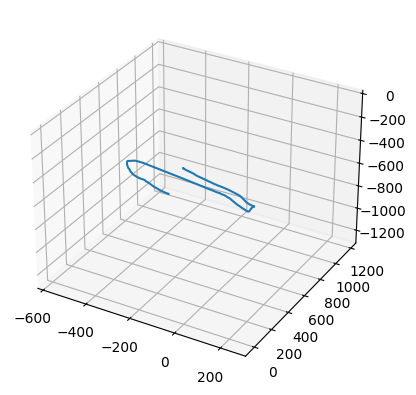

In [54]:
plot_trajectory(ACCELERATIONS, YAW_RATES, TIMESTAMPS)

# Anna's dataset, flat rectangle

In [55]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Anna_flat_2/SM2_B1A104.csv"
dataset = pd.read_csv(url)
dataset = normalize(dataset)

TIMESTAMPS    = np.arange(0, dataset.accel_z.size, 1)
YAW_RATES = [dataset.gyro_x, dataset.gyro_y, dataset.gyro_z]
ACCELERATIONS = [dataset.accel_x, dataset.accel_y, dataset.accel_z]

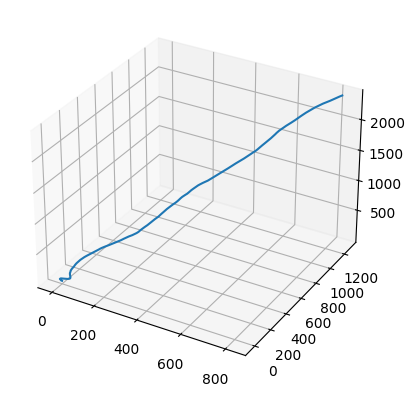

In [56]:
plot_trajectory(ACCELERATIONS, YAW_RATES, TIMESTAMPS)

# Anna's dataset, moving up and down

In [57]:
url = "https://raw.githubusercontent.com/AnnaRemi/Lab_trajectiories/main/_sessions/Anna_up_1/SM2_B1A104.csv"
dataset = pd.read_csv(url)
dataset = normalize(dataset)

TIMESTAMPS    = np.arange(0, dataset.accel_z.size, 1)
YAW_RATES = [dataset.gyro_x, dataset.gyro_y, dataset.gyro_z]
ACCELERATIONS = [dataset.accel_x, dataset.accel_y, dataset.accel_z]

In [58]:
dataset.head()

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.011230,-0.026123,0.051880,11.032104,-3.372192,0.305176
2,-0.013916,-0.033447,0.063843,35.217285,-10.284424,1.052856
3,-0.009277,-0.024414,0.039429,62.042236,-18.112183,1.632690
4,-0.000977,-0.003540,-0.007568,82.687378,-24.353027,1.998901


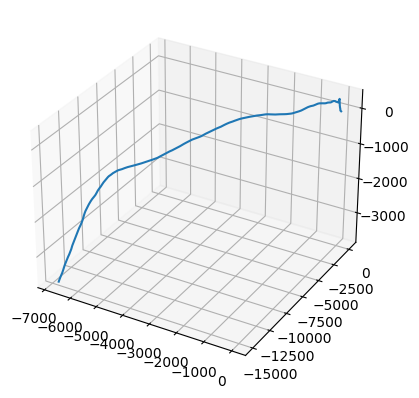

In [59]:
plot_trajectory(ACCELERATIONS, YAW_RATES, TIMESTAMPS)